# Synopsis
Smart-Yoga Pillow (SaYopillow) is a Smart Pillow connected to a wireless tracker to monitor sleeping habits to determine stress levels. 

- Data Exploration
- Build multi-linear regression model to predict snoring rate
- Cluster and re-label stress levels using k-means clustering

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Data Exploration 

Start off by reading in the csv file as a dataframe and grabbing a few rows of data to observe.
1. snoring range of the user 
2. respiration rate (The number of breaths you take per minute. The normal respiration rate for an adult at rest is 12 to 20 breaths per minute.)
3. body temperature (Fahrenheit)
4. limb movement rate (measured in seconds)
5. blood oxygen levels (measured in percentages, 90% - 100% is the normal range)
6. eye movement (when going through REM sleep, our eyes dart around and this is one of the reasons why we may have dreams)
7. number of hours of sleep
8. heart rate (BPM = beats per minute)
9. Stress Levels (0- low/normal, 1 – medium low, 2- medium, 3-medium high, 4 -high)

In [2]:
# Get data from csv file and rename columns
df = pd.read_csv('SaYoPillow.csv',
                 names= ['snoring_rate','respiration_rate','body_temperature','limb_movement','blood_oxygen',
                        'eye_movement','sleeping_hours','heart_rate','stress_level'],header = 0)
df.head()

,snoring_rate,respiration_rate,body_temperature,limb_movement,blood_oxygen,eye_movement,sleeping_hours,heart_rate,stress_level
0,93.80,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.64,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.00,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.76,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0


Here are the stats of each column (ex: min, max, count). There are 630 records in this dataset and on average the stress level for this dataset is 2.

In [3]:
# Stats of the dataset
round(df.describe(),2)

,snoring_rate,respiration_rate,body_temperature,limb_movement,blood_oxygen,eye_movement,sleeping_hours,heart_rate,stress_level
count,630.00,630.00,630.00,630.00,630.00,630.00,630.00,630.00,630.00
mean,71.60,21.80,92.80,11.70,90.90,88.50,3.70,64.50,2.00
std,19.37,3.97,3.53,4.30,3.90,11.89,3.05,9.92,1.42
min,45.00,16.00,85.00,4.00,82.00,60.00,0.00,50.00,0.00
25%,52.50,18.50,90.50,8.50,88.50,81.25,0.50,56.25,1.00
50%,70.00,21.00,93.00,11.00,91.00,90.00,3.50,62.50,2.00
75%,91.25,25.00,95.50,15.75,94.25,98.75,6.50,72.50,3.00
max,100.00,30.00,99.00,19.00,97.00,105.00,9.00,85.00,4.00


Creating a histogram of the stress levels, we get an uniform distribution. This dataset is very well-balanced and will be easy to use for analysis.

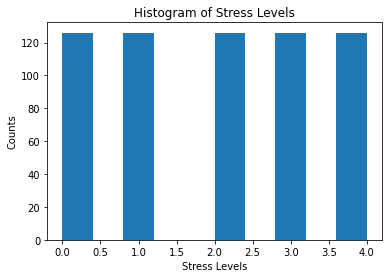

In [4]:
# Histogram of stress levels
plt.hist(df['stress_level'])

plt.title('Histogram of Stress Levels')
plt.xlabel('Stress Levels')
plt.ylabel('Counts')

plt.show() 

## Question 1:
Can I predict the snoring rate based on other features that SayoPillow collected? How accurate is my model and can I improve it by removing certain features?

Text(0.5, 1.01, 'SayoPillow Features Correlation Matrix')

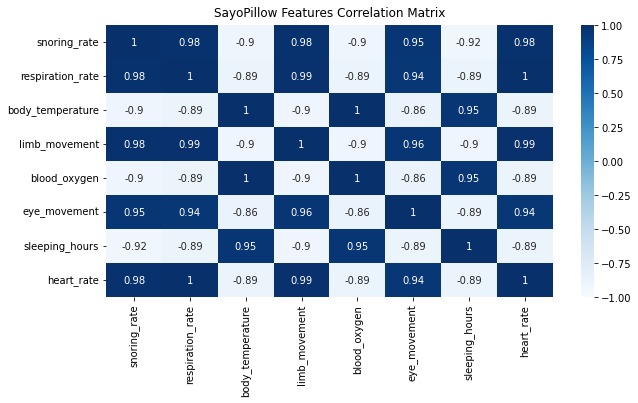

In [5]:
# Correlation matrix on a heatmap
matrix =df.iloc[:,:-1].corr().round(2)
plt.figure(figsize = (10,5))
lit = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap="Blues")
lit.set_title("SayoPillow Features Correlation Matrix",y=1.01)

The heatmap above shows that most of these features are very highly correlated, lets see if we can get a range of the correlation coefficient.

In [6]:
# After removing the stress level column, get ONLY the upper half of the correlation matrix,
# then create a dataframe of the correlations
corr_df = df.iloc[:,:-1].corr().where(np.triu(np.ones(df.iloc[:,:-1].corr().shape), k=1).astype(bool)).stack().reset_index()
corr_df.columns = ['first_feat','second_feat','corr']
corr_df = corr_df.sort_values(by=['corr']).reset_index(drop = True)


corr_df['corr'] = round(corr_df['corr'],2)
corr_df_positive = corr_df[corr_df['corr'] > 0 ].reset_index(drop = True)
corr_df_negative =corr_df[corr_df['corr'] < 0 ].reset_index(drop = True)

Here are the negativly correlated features and their correlation coefficient.

In [7]:
# Look at negative correlations only
corr_df_negative

,first_feat,second_feat,corr
0,snoring_rate,sleeping_hours,-0.92
1,snoring_rate,blood_oxygen,-0.90
2,snoring_rate,body_temperature,-0.90
3,limb_movement,sleeping_hours,-0.90
4,limb_movement,blood_oxygen,-0.90
5,body_temperature,limb_movement,-0.90
6,eye_movement,sleeping_hours,-0.89
7,respiration_rate,sleeping_hours,-0.89
8,sleeping_hours,heart_rate,-0.89
9,body_temperature,heart_rate,-0.89


Here are the positively correlated features and their correlation coefficient.

In [8]:
# Look at positive correlations only
corr_df_positive

,first_feat,second_feat,corr
0,eye_movement,heart_rate,0.94
1,respiration_rate,eye_movement,0.94
2,blood_oxygen,sleeping_hours,0.95
3,snoring_rate,eye_movement,0.95
4,body_temperature,sleeping_hours,0.95
5,limb_movement,eye_movement,0.96
6,snoring_rate,respiration_rate,0.98
7,snoring_rate,heart_rate,0.98
8,snoring_rate,limb_movement,0.98
9,respiration_rate,limb_movement,0.99


In [9]:
print('The absolute correlation range is ['+ str(min(abs(corr_df['corr']))) + ' to '+ str(max(abs(corr_df['corr']))) + ']')

The absolute correlation range is [0.86 to 1.0]


The absolute correlation range is 0.86 to 1.0 meaning that most of these features are highly correlated and the ones with a correlation coefficient of 1.0 should be considered for removal.

Now we can start building the multi-linear regression model with all the features. Here are the steps to creating the model:

Steps:
1. Split data into testing & training
2. Fit training set into multi linear regression model
3. Calculate accuracy and SSE
4. Remove features to see if the accuracy went up and SSE will go down 

In [10]:
# Split 60/40 for training & test set
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,1:-1],df['snoring_rate'],test_size=0.4, random_state=3)

In [12]:
# Fit multi linear regression model
regr = linear_model.LinearRegression()
regr.fit(X_train.values, y_train)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 76734907293452.08
Coefficients: 
 [ 1.91837268e+13  1.55078125e+00  1.95800781e+00 -1.06713867e+00
  7.17773438e-02 -1.59155273e+00 -7.67349073e+12]


In [29]:
# This is the multi linear regression model
print('This is the multi-linear regression model w/ all the features:')
print('y = ',end='')
for i in range(len(regr.coef_)):
    print('(' + str(regr.coef_[i]) + ')*(' + X_train.columns[i] + ') + ',end='')
print(regr.intercept_)

This is the multi-linear regression model w/ all the features:
y = (19183726823373.3)*(respiration_rate) + (1.55078125)*(body_temperature) + (1.9580078125)*(limb_movement) + (-1.067138671875)*(blood_oxygen) + (0.07177734375)*(eye_movement) + (-1.591552734375)*(sleeping_hours) + (-7673490729348.662)*(heart_rate) + 76734907293452.08


In [14]:
# Get predicted snoring ratevalues using multi linear regression model
y_pred =  regr.predict(X_test.values)

# Calculate SSE
SSE = round(sum(((y_test - y_pred)**2)),2)

# Calculate accuracy
acc_score = regr.score(X_test.values,y_test)
print('The accuracy for the above multi-linear regression model ' + str(round(acc_score*100,2)) + '% and the SSE = ' + str(SSE))

The accuracy for the above multi-linear regression model 96.86% and the SSE = 2841.42


The accuracy given by the original documentation of SayoPillow is 96%. Therefore, our multi-linear regression model is about 1% better than the original documentation.

In [15]:
# Feature removal
def exclude_features(feats):
    '''
    Provide the accuracy of the multi-linear regression model AFTER removing certaon features
    
    Parameters:
    feats - features we will be removing
    '''
    # Create new dataframe w/ certain features removed
    exclude_list = feats
    df_exlude = df[df.iloc[:,:-1].columns[~df.iloc[:,:-1].columns.isin(exclude_list)]]


    # Split 60/40 for training & test set
    X_train_remove,X_test_remove,y_train_remove,y_test_remove = train_test_split(df_exlude.iloc[:,1::],df_exlude['snoring_rate'],test_size=0.4, random_state=3)

    # Fit model
    regr_remove = linear_model.LinearRegression()
    regr_remove.fit(X_train_remove.values, y_train_remove)

    # Predicted values 
    y_pred_remove =  regr_remove.predict(X_test_remove.values)
    
    # SSE
    SSE_remove = round(sum(((y_test - y_pred_remove)**2).values),2)

    # Accuracy score
    acc_score_remove = regr_remove.score(X_test_remove.values,y_test_remove)
    print('The accuracy is ' + str(round(acc_score_remove*100,2)) + '% and the SSE = ' + str(SSE_remove) + ' after removing ' + 
          str(exclude_list))

exclude_features(['respiration_rate','blood_oxygen'])
exclude_features(['respiration_rate','body_temperature'])
exclude_features(['heart_rate','body_temperature'])
exclude_features(['heart_rate','blood_oxygen'])
exclude_features(['blood_oxygen'])
exclude_features(['body_temperature'])
exclude_features(['respiration_rate'])
exclude_features(['heart_rate'])

The accuracy is 96.88% and the SSE = 2829.21 after removing ['respiration_rate', 'blood_oxygen']
The accuracy is 96.88% and the SSE = 2825.82 after removing ['respiration_rate', 'body_temperature']
The accuracy is 96.88% and the SSE = 2825.82 after removing ['heart_rate', 'body_temperature']
The accuracy is 96.88% and the SSE = 2829.21 after removing ['heart_rate', 'blood_oxygen']
The accuracy is 96.88% and the SSE = 2827.78 after removing ['blood_oxygen']
The accuracy is 96.88% and the SSE = 2825.85 after removing ['body_temperature']
The accuracy is 96.86% and the SSE = 2847.43 after removing ['respiration_rate']
The accuracy is 96.86% and the SSE = 2847.43 after removing ['heart_rate']


Even if we remove the features that have a correlation coefficient of 1.0, the accuracy increased only 0.02% (96.88% - 96.86%), which is not very significant. After removing the respiration_rate and body_temperature or heart_rate and body_temperature features, the original SSE w/ all features (2841.42) decreased slightly (about 15.6, 2841.42 - 2825.82). Therefore, removing features from the multi-linear regression model will not benefit my analysis.

# Question 2: 
There are 5 labels to classify the different stress levels (0-4) at the moment. Can I reduce and simplify the labels?

To reduce and simplify the labels, lets use k-means clustering and follow the below steps. I will be using both scaled features and unscaled features versions of k-means clustering:

Steps:
1. Find the ideal k using the elbow method
2. Fit the k-means model on the ideal k
3. Create a new column for the predicted values (clusters)
4. For each feature, get the min and max after aggregating by new labels

In [16]:
def scaling_test(usage):
    '''
    Calculate the distortions per k, create an elbow plot, create a k-means plot (on snoring rate vs blood oxygen)
    
    Paramters:
    usage - "scaled" or "unscaled" are the options to determine whether we want to scale the features or not
    
    Return:
    1. Aggregated dataframe containing the clusters, original stress levels and the count for each group
    2. Cluster labels given the scaled or unscaled version of k-means
    
    '''
    # Plot labels
    elbow_title = 'The Elbow Method showing the optimal k'
    k_means_x = 'snoring rate'
    k_means_y = 'blood oxygen'
    k_means_title  = 'Snoring Rate VS Blood Oxygen K-means Plot'
    
    if usage == 'scaled':
        # Scale features
        scaler = StandardScaler()
        scaler.fit(df.iloc[:,:-1])
        df_usage = scaler.transform(df.iloc[:,:-1])
        df_usage = pd.DataFrame(df_usage,columns= ['snoring_rate','respiration_rate','body_temperature','limb_movement','blood_oxygen',
                        'eye_movement','sleeping_hours','heart_rate'])
        # Plot labels
        elbow_title = elbow_title + ' (scaled)'
        k_means_x = k_means_x + ' (scaled)'
        k_means_y = k_means_y + ' (scaled)'
        k_means_title = k_means_title + ' (scaled)'
        
    elif usage  == 'unscaled': 
        df_usage = df.iloc[:,:-1]
    
    
    # Test which k from 1- 10 would be the ideal k 
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k,random_state = 8)
        kmeanModel.fit(df_usage)
        distortions.append(kmeanModel.inertia_)
        
   
    # After calculating the sum of square distances (distortion), we look at the plot and see that
    # k = 3 is the optimal k since after 3, the sum of square distances starts decreasing less quickly.
    
    # Plot on same line as k-means plot (later)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize =(13,5))
    
    ax1.plot(K, distortions, 'bx-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Sum of Squared Distances Within Centroid (Distortion)')
    ax1.set_title(elbow_title)
        

    
    # k = 3 is best k, so we fit the data and get the clusters and assign it as a new column
    kmeanModel = KMeans(n_clusters=3,random_state = 8)
    clusters = kmeanModel.fit(df_usage)
    df_usage['cluster'] = clusters.labels_
    # Get the centroids
    centroids  = clusters.cluster_centers_
    
    
    
    # Plot k-means using only 2 features
    df_usage_2 = df_usage[['snoring_rate','blood_oxygen','cluster']]

    # Plot the centroids and the clusters
    ax2.scatter(df_usage_2[df_usage_2['cluster'] == 0].iloc[:,0], df_usage_2[df_usage_2['cluster'] == 0].iloc[:,1],
                    s = 75, c ='red', label = 'cluster 0')
    ax2.scatter(df_usage_2[df_usage_2['cluster'] == 1].iloc[:,0], df_usage_2[df_usage_2['cluster'] == 1].iloc[:,1],
                    s = 75, c = 'blue', label = 'cluster 1')
    ax2.scatter(df_usage_2[df_usage_2['cluster'] == 2].iloc[:,0], df_usage_2[df_usage_2['cluster'] == 2].iloc[:,1],
                    s = 75, c = 'green', label = 'cluster 2')
    ax2.scatter(centroids[:,0],centroids[:,4],
                    s = 200 , c = 'black', label = 'Centroids')

    ax2.legend()
    ax2.set_xlabel(k_means_x)
    ax2.set_ylabel(k_means_y)
    ax2.set_title(k_means_title)
    plt.tight_layout()
    
    
    # Get aggregation cluster
    df_usage_3 = df_usage_2
    df_usage_3['stress_level'] = df['stress_level']
    
    # This is an aggregated dataframe to see the various counts of stress levels per cluster so we can see how we 
    # want to group the data later.
    test = df_usage_3.groupby(['cluster','stress_level']).count()[['snoring_rate']].rename({'snoring_rate':'counts'},axis = 1)
    
    
    
    return [test,clusters.labels_]

counts
cluster stress_level        
0       2                126
        3                126
1       0                126
        1                126
2       4                126

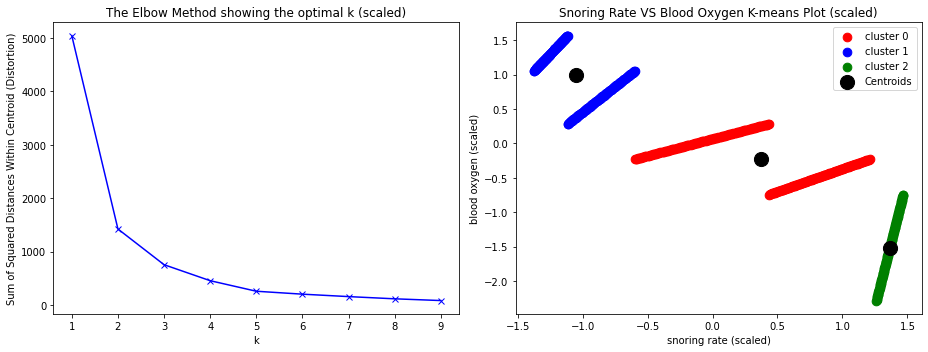

In [17]:
# Scaled features k-means results
scaling_test('scaled')[0]

counts
cluster stress_level        
0       3                 83
        4                126
1       0                126
        1                126
2       2                126
        3                 43

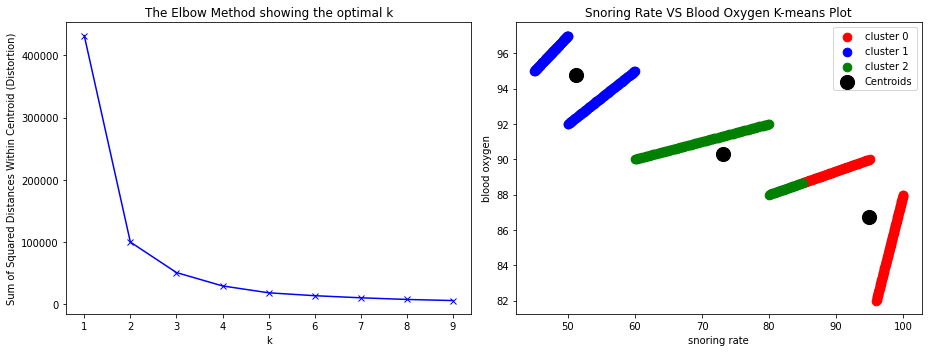

In [18]:
# Unscaled features k-means results
scaling_test('unscaled')[0]

In the above plots, I have plotted the elbow plot, k-means plot using snoring rate vs blood oxygen as an example and an aggregated table of the clusters and the original stress level labels counts. For the elbow plot, regardless of scaled or not for the features, k= 3 is the optimal k to use for my k-means model. As for the k-means plot and aggregated table, there is a very large difference when using scaled and unscaled features. For the scaled features, the data is separated perfectly into each cluster. For unscaled features, cluster 0 and 2 have a small chunk of data that both belong in stress level 3, which was determined by using the unscaled aggregated table.

In [19]:
# Replicate the original dataframe to use for later
df_copy = df.copy()


# Scaled
# Using k-means, there are 3 distinct clusters instead of 5 different stress levels. 
# The 3 clusters inform me on which stress levels i can group together to form new labels
# Cluster 1 = not stressed: 0 - 1
# Cluster 0 = stressed: 2 - 3 
# Cluster 2 = overly stressed: 4 
df_copy['simplified_stress_lvl_scaled'] = df_copy.apply(lambda x:'Not Stressed' if x['stress_level'] < 2 
                                       else('Over Stressed' if x['stress_level'] > 3 else 'Stressed'),axis = 1)


# Unscaled
# Using k-means, there are 3 distinct clusters instead of 5 different stress levels. 
# The 3 clusters inform me on which stress levels i can group together to form new labels
# Cluster 1 = not stressed: 0 - 1
# Cluster 2 = stressed: 2 (3 could have been included, but cluster 0 has more stress level 3s than cluster 2)
# Cluster 0 = overly stressed: 3 - 4 
df_copy['simplified_stress_lvl_unscaled'] = df_copy.apply(lambda x:'Not Stressed' if x['stress_level'] < 2 
                                       else('Over Stressed' if x['stress_level'] > 2 else 'Stressed'),axis = 1)


Now I will group the stress levels based on the clusters and create new labels. I will just call them "simplified_stress_lvl".

For scaled features, cluster 1 equals not stressed (stress levels 0 - 1), cluster 0 equals stressed (stress levels 2 -3) and 
cluster 2 stands for overly stressed (stress level 4).

For unscaled features, cluster 1 equals not stressed (stress levels 0 - 1), cluster 2 equals stressed (stress level 2) and 
cluster 0 stands for overly stressed (stress level 3-4). Again, stress level 3 belonged in both cluster 0 and 2, but 0 had more counts of stress level 3 so I made the decision to consider 3 as overly stressed.

In [20]:
# Get min and max values for each column to see what the range is for each feature (scaled)
df_scaled = df_copy.groupby('simplified_stress_lvl_scaled').agg({'snoring_rate':['min','max'],'respiration_rate':['min','max'],
                                         'body_temperature':['min','max'],'limb_movement':['min','max'],
                                          'blood_oxygen':['min','max'],'eye_movement':['min','max'],
                                         'sleeping_hours':['min','max'], 'heart_rate':['min','max']})
df_scaled = df_scaled.reindex(index = ['Not Stressed','Stressed','Over Stressed'])
df_scaled

snoring_rate        respiration_rate        \
                                      min    max              min   max   
simplified_stress_lvl_scaled                                              
Not Stressed                         45.0   60.0             16.0  20.0   
Stressed                             60.0   95.0             20.0  26.0   
Over Stressed                        96.0  100.0             26.0  30.0   

                             body_temperature       limb_movement        \
                                          min   max           min   max   
simplified_stress_lvl_scaled                                              
Not Stressed                             94.0  99.0           4.0  10.0   
Stressed                                 90.0  94.0          10.0  17.0   
Over Stressed                            85.0  90.0          17.0  19.0   

                             blood_oxygen       eye_movement         \
                                      min   max          min    max   
simplified_stress_lvl_scaled                                          
Not Stressed                         92.0  97.0         60.0   85.0   
Stressed                             88.0  92.0         85.0  100.0   
Over Stressed                        82.0  88.0        100.0  105.0   

                             sleeping_hours      heart_rate        
                                        min  max        min   max  
simplified_stress_lvl_scaled                                       
Not Stressed                            5.0  9.0       50.0  60.0  
Stressed                                0.0  5.0       60.0  75.0  
Over Stressed                           0.0  0.0       75.0  85.0

In [21]:
# Get min and max values for each column to see what the range is for each feature (unscaled)
df_unscaled = df_copy.groupby('simplified_stress_lvl_unscaled').agg({'snoring_rate':['min','max'],'respiration_rate':['min','max'],
                                         'body_temperature':['min','max'],'limb_movement':['min','max'],
                                          'blood_oxygen':['min','max'],'eye_movement':['min','max'],
                                         'sleeping_hours':['min','max'], 'heart_rate':['min','max']})
df_unscaled = df_unscaled.reindex(index = ['Not Stressed','Stressed','Over Stressed'])
df_unscaled

snoring_rate        respiration_rate        \
                                        min    max              min   max   
simplified_stress_lvl_unscaled                                              
Not Stressed                           45.0   60.0             16.0  20.0   
Stressed                               60.0   80.0             20.0  22.0   
Over Stressed                          80.0  100.0             22.0  30.0   

                               body_temperature       limb_movement        \
                                            min   max           min   max   
simplified_stress_lvl_unscaled                                              
Not Stressed                               94.0  99.0           4.0  10.0   
Stressed                                   92.0  94.0          10.0  12.0   
Over Stressed                              85.0  92.0          12.0  19.0   

                               blood_oxygen       eye_movement         \
                                        min   max          min    max   
simplified_stress_lvl_unscaled                                          
Not Stressed                           92.0  97.0         60.0   85.0   
Stressed                               90.0  92.0         85.0   95.0   
Over Stressed                          82.0  90.0         95.0  105.0   

                               sleeping_hours      heart_rate        
                                          min  max        min   max  
simplified_stress_lvl_unscaled                                       
Not Stressed                              5.0  9.0       50.0  60.0  
Stressed                                  2.0  5.0       60.0  65.0  
Over Stressed                             0.0  2.0       65.0  85.0

For both scaled and unscaled features, I wanted the range of each feature given the original dataset to be grouped by the new "simplified_stress_lvl" labels I created. Based on the k-means plot from earlier, using the scaled features would be the ideal strategy. However, I prefer the unscaled features range of each feature. 

In the tables above, the new label "Over Stressed" has a larger range for unscaled features than (ex: snoring rate is 80-100) the scaled features (96-100). In the real world, we would want to detect if someone is overly stressed earlier to make sure they receive the proper treatment in time such as more sleep. If we used the scaled features, we might be classifying someone as "Stressed" even though they have already achieved the "Over Stressed" level.

# Links/ Resources
https://www.smohanty.org/Presentations/2018/Mohanty_iSES-2018_Smart-Pillow_Talk.pdf (SaYo Pillow info)

https://www.kaggle.com/datasets/laavanya/human-stress-detection-in-and-through-sleep?select=SaYoPillow.csv (dataset)

https://datatofish.com/multiple-linear-regression-python/ (multi-linear regression model)

https://predictivehacks.com/k-means-elbow-method-code-for-python/ (k-means)